In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data=pd.read_csv('train.csv')

In [77]:
test=pd.read_csv('test.csv')

## Data structure and distribution

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
len(data), len(test)

(891, 418)

In [6]:
data.isnull().sum() #checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

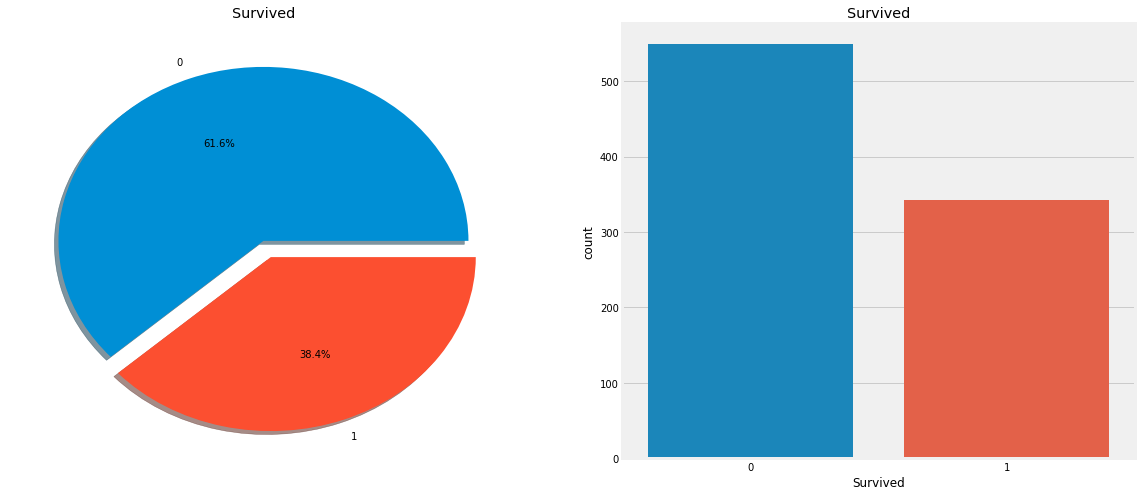

In [8]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

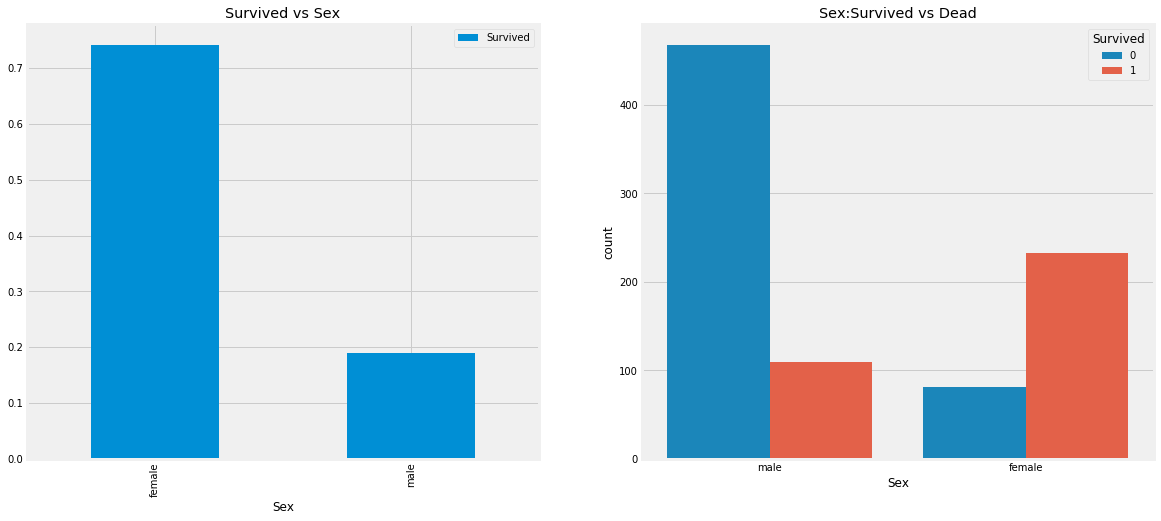

In [9]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

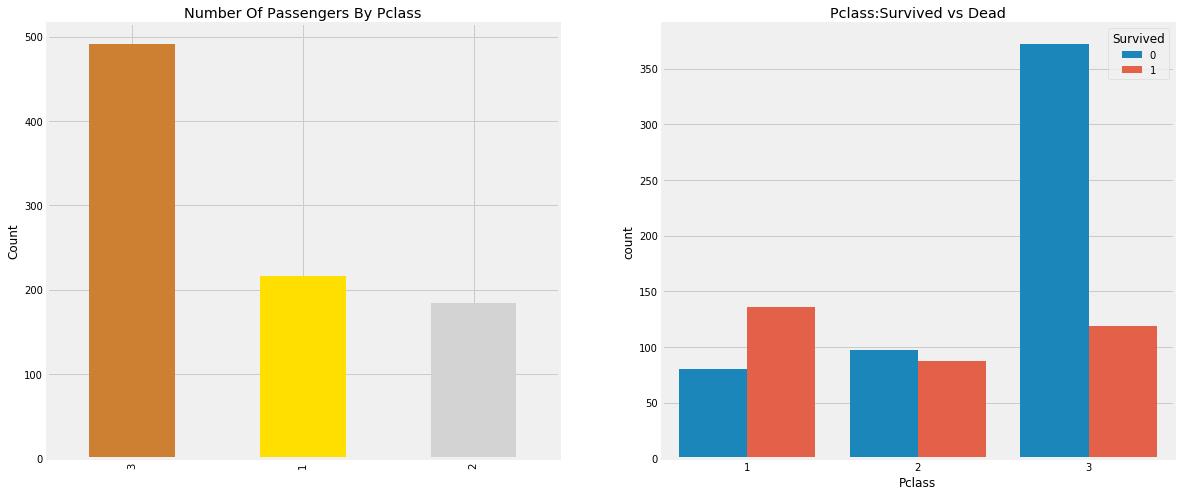

In [10]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

In [11]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


In [12]:
print('Oldest Passenger was of:',test['Age'].max(),'Years')
print('Youngest Passenger was of:',test['Age'].min(),'Years')
print('Average Age on the ship:',test['Age'].mean(),'Years')

Oldest Passenger was of: 76.0 Years
Youngest Passenger was of: 0.17 Years
Average Age on the ship: 30.272590361445783 Years


## Data Clean

### 1. Deal with missing data (Non values)
#### 1.1 Age

In [13]:
def age_clean(data):
    data['without_age'] = 0
    data.loc[data['Age'].isnull() == 1, ['without_age']] = 1
    data.loc[data['Age'].isnull() == 1, ['Age']] = -1
    return data

In [14]:
data = age_clean(data)

#### 1.2 Cabin

In [15]:
def cabin_clean(data):
    data['without_cabin'] = 0
    data.loc[data['Cabin'].isnull() == 1, ['without_cabin']] = 1
    data.loc[data['Cabin'].isnull() == 1, ['Cabin']] = 'Non'
    return data

In [16]:
data = cabin_clean(data)
#data['Cabin'][:20]

#### 1.3 Embarked

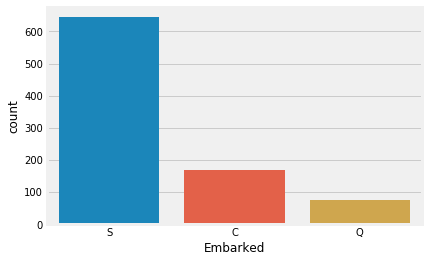

In [17]:
sns.countplot('Embarked',data=data)

In [18]:
data[data['Embarked'].isnull() == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,without_age,without_cabin
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,0


In [19]:
def embarked_clean(data):
    #test set does not have any nan values at embarked
    #just replace it with most_common value, which is S
    data.loc[data['Embarked'].isnull() == 1, ['Embarked']] = 'S'
    return data

data = embarked_clean(data)
#data[data['Embarked'].isnull() == 1]

#### 1.4 Fare

In [20]:
test[test['Fare'].isnull() == 1]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [21]:
def fare_clean(data):
    #only for test data
    #replace it with 0
    data.loc[data['Fare'].isnull() == 1, ['Fare']] = 0
    return data

## Text Mining & Data Categorizing

In [22]:
# import necessary modules 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

### 1 Separate Name Data

In [23]:
def creat_name_data(data):
    '''
    name example: Braund, Mr. Owen Harris
    title: Braund
    call: Mr.
    '''
    try: 
        data['Name']
    except: 
        return data
    name_data = pd.Series(data['Name'])
    title_data = pd.DataFrame(name_data.str.split(',', expand = True)).rename(columns = {0: 'Title', 1: 'Name'})
    name_data = title_data['Name'].str.strip()
    call_data = name_data.str.findall(r'([CDJLSMR][a-z]+)[.]').apply(''.join).reset_index()
    #extractall might leak data without target words

    other_data = name_data.str.findall(r'[(][A-Za-z.\s]+[)]').apply(''.join).reset_index()
    other_data.loc[other_data['Name'] != '', ['Name']] = 1
    other_data.loc[other_data['Name'] == '', ['Name']] = 0
    
    #update data with mined text values
    data['name_title'] = title_data['Title']
    data['name_call'] = call_data['Name']
    data['name_has_other_names'] = other_data['Name']
    
    #one-hot-coding for name_call
    data = data.join(pd.get_dummies(data['name_call'], prefix = 'call', drop_first = True))
    
    #no need Name column anymore, name_title is too diverse and hard to do one-hot-coding #667 unique titles
    data.drop(columns = ['Name', 'name_title', 'name_call'], inplace = True)
    
    return data

In [24]:
data = creat_name_data(data)

data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,call_Major,call_Master,call_Miss,call_Mlle,call_Mme,call_Mr,call_Mrs,call_Ms,call_Rev,call_Sir
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,Non,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,...,0,0,0,0,0,0,1,0,0,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Non,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,...,0,0,0,0,0,0,1,0,0,0
4,5,0,3,male,35.0,0,0,373450,8.0500,Non,...,0,0,0,0,0,1,0,0,0,0


### 2  Sex (one-hot)

In [25]:
def get_dummy_sex(data):
    data = data.join(pd.get_dummies(data['Sex'], prefix = 'sex', drop_first = True))
    data.drop(columns = ['Sex'], inplace = True)
    return data

In [26]:
data = get_dummy_sex(data)
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,call_Master,call_Miss,call_Mlle,call_Mme,call_Mr,call_Mrs,call_Ms,call_Rev,call_Sir,sex_male
0,1,0,3,22.0,1,0,A/5 21171,7.2500,Non,S,...,0,0,0,0,1,0,0,0,0,1
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,C,...,0,0,0,0,0,1,0,0,0,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,Non,S,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,35.0,1,0,113803,53.1000,C123,S,...,0,0,0,0,0,1,0,0,0,0
4,5,0,3,35.0,0,0,373450,8.0500,Non,S,...,0,0,0,0,1,0,0,0,0,1


### 3 Embarked (one-hot)

In [27]:
def get_dummy_embarked(data):
    data = data.join(pd.get_dummies(data['Embarked'], prefix = 'embarked', drop_first = True))
    data.drop(columns = ['Embarked'], inplace = True)
    return data

In [28]:
data = get_dummy_embarked(data)
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,without_age,...,call_Mlle,call_Mme,call_Mr,call_Mrs,call_Ms,call_Rev,call_Sir,sex_male,embarked_Q,embarked_S
0,1,0,3,22.0,1,0,A/5 21171,7.2500,Non,0,...,0,0,1,0,0,0,0,1,0,1
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,Non,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,35.0,1,0,113803,53.1000,C123,0,...,0,0,0,1,0,0,0,0,0,1
4,5,0,3,35.0,0,0,373450,8.0500,Non,0,...,0,0,1,0,0,0,0,1,0,1


### 4 Cabin

In [29]:
#len(data['Cabin'].unique()) #148 unique items, should group data with starting character
#set(data['Cabin'].str.findall(r'([N]\w+)').apply("".join).tolist()) #no Cabin started at N except NaN values
def get_dummy_cabin(data):
    #extract the first character of cabin data
    data['cabin_c'] = data['Cabin'].str.findall(r'(^[A-Z])[\d]').apply("".join)
    #plotting survival by different cabins
    #sns.countplot('cabin_c',hue='Survived',data=data)
    
    #one-hot-coding
    data = data.join(pd.get_dummies(data['cabin_c'], prefix = 'cabin_loc', drop_first = True))
    #no need Cabin and cabin_c anymore
    data.drop(columns = ['Cabin', 'cabin_c'], inplace = True)
    return data

In [30]:
data = get_dummy_cabin(data)
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,without_age,without_cabin,...,sex_male,embarked_Q,embarked_S,cabin_loc_A,cabin_loc_B,cabin_loc_C,cabin_loc_D,cabin_loc_E,cabin_loc_F,cabin_loc_G
0,1,0,3,22.0,1,0,A/5 21171,7.2500,0,1,...,1,0,1,0,0,0,0,0,0,0
1,2,1,1,38.0,1,0,PC 17599,71.2833,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,0,1,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,35.0,1,0,113803,53.1000,0,0,...,0,0,1,0,0,1,0,0,0,0
4,5,0,3,35.0,0,0,373450,8.0500,0,1,...,1,0,1,0,0,0,0,0,0,0


### 5 Ticket

In [31]:
#extract ticket types
#data['Ticket'].str.split(r'[\d]+$').apply("".join).str.strip().unique() #45 unique ticket types

In [32]:
#test['Ticket'].str.split(r'[\d]+$').apply("".join).str.strip().unique()

In [33]:
def get_dummy_ticket(data):
    #more general types #replace to simplify data more
    data['ticket_type'] = data['Ticket'].str.split(r'[\d]+$'
                                              ).apply("".join).str.strip().str.replace('.', 
                                              "").str.split(r'[/ ]').apply(''.join).str.findall(
                                              r'[\w]*([A-Z]\d|[A-Z])[\w]*').apply("".join)

    #plt.figure(figsize = (18,8))
    #sns.countplot('ticket_type',hue='Survived',data=data)
    
    #one-hot-coding
    data = data.join(pd.get_dummies(data['ticket_type'], prefix = 'ticket', drop_first = True))
    #no need Ticket and ticket_type anymore
    data.drop(columns = ['Ticket', 'ticket_type'], inplace = True)
    
    return data

In [34]:
data = get_dummy_ticket(data)
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,...,ticket_C,ticket_E,ticket_F,ticket_H,ticket_N,ticket_O2,ticket_P,ticket_Q,ticket_S,ticket_W
0,1,0,3,22.0,1,0,7.2500,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,3,35.0,0,0,8.0500,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 6 Alone Passenger

In [45]:
def alone_checker(data):
    data['alone'] = 0
    #set 
    data.loc[(data['SibSp'] == 0) & (data['Parch'] == 0), ['alone']] = 1
    return data

In [46]:
data = alone_checker(data)
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,...,ticket_E,ticket_F,ticket_H,ticket_N,ticket_O2,ticket_P,ticket_Q,ticket_S,ticket_W,alone
0,1,0,3,22.0,1,0,7.2500,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,3,35.0,0,0,8.0500,0,1,0,...,0,0,0,0,0,0,0,0,0,1


### 7 One-hot Pclass

In [47]:
def one_hot_pclass(data):
    data = data.join(pd.get_dummies(data['Pclass'], prefix = 'pclass', drop_first = True))
    data.drop(columns = ['Pclass'], inplace = True)
    return data

In [48]:
data = one_hot_pclass(data)
data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,call_Col,...,ticket_H,ticket_N,ticket_O2,ticket_P,ticket_Q,ticket_S,ticket_W,alone,pclass_2,pclass_3
0,1,0,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,38.0,1,0,71.2833,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
3,4,1,35.0,1,0,53.1000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1


### 8 Age Groups

In [54]:
def age_group(data):
    categories = ['Baby', 'Child','Teenager', 'Youth', 'Adult', 'Elder']
    
    for cat in categories:
        data[cat] = 0
    data.loc[data['Age'] < 4, ['Baby']] = 1
    data.loc[(data['Age'] < 12) & (data['Age'] >= 4), ['Child']] = 1
    data.loc[(data['Age'] < 18) & (data['Age'] >= 12), ['Teenager']] = 1
    data.loc[(data['Age'] < 30) & (data['Age'] >= 18), ['Youth']] = 1
    data.loc[(data['Age'] < 55) & (data['Age'] >= 30), ['Adult']] = 1
    data.loc[data['Age'] >= 55, ['Elder']] = 1
    
    # drop Age column
    data.drop(columns = ['Age'], inplace = True)
    
    return data

In [55]:
data = age_group(data)
data.head()

,PassengerId,Survived,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,call_Col,call_Countess,...,ticket_W,alone,pclass_2,pclass_3,Baby,Child,Teenager,Youth,Adult,Elder
0,1,0,1,0,7.2500,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2,1,1,0,71.2833,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,7.9250,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,4,1,1,0,53.1000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,8.0500,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


## Try ML

In [56]:
data.set_index('PassengerId', inplace = True)
data.head()

,Survived,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,call_Col,call_Countess,call_Don,...,ticket_W,alone,pclass_2,pclass_3,Baby,Child,Teenager,Youth,Adult,Elder
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,7.2500,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,1,0,71.2833,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,7.9250,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
4,1,1,0,53.1000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,8.0500,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [57]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

from sklearn.preprocessing import MinMaxScaler #normalization

In [119]:
train,testing=train_test_split(data, test_size=0.2,random_state=33, stratify=data['Survived'])
X_train = train[train.columns[1:]]
Y_train = train[train.columns[:1]]
X_test = testing[testing.columns[1:]]
Y_test = testing[testing.columns[:1]]

In [120]:
#normalization
scalar = MinMaxScaler()
X_train[['Fare', 'SibSp', 'Parch']] = scalar.fit_transform(X_train[['Fare', 'SibSp', 'Parch']])
X_test[['Fare', 'SibSp', 'Parch']] = scalar.transform(X_test[['Fare', 'SibSp', 'Parch']])

In [130]:
#Try RFC
clf = RandomForestClassifier(n_estimators = 55)
clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)
metrics.accuracy_score(prediction, Y_test)

0.8044692737430168

In [131]:
#Decision Tree
model=DecisionTreeClassifier()
model.fit(X_train,Y_train)
prediction=model.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,Y_test))

The accuracy of the Decision Tree is 0.7877094972067039


In [132]:
#SVC
clf = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                        decision_function_shape='ovr', degree=3, gamma=0.03, kernel='rbf',
                        max_iter=-1, probability=False, random_state=None, shrinking=True,
                        tol=0.001, verbose=False)

clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)
metrics.accuracy_score(prediction, Y_test)

0.8100558659217877

## Jobs for test set and Submission

In [104]:
test=pd.read_csv('test.csv')

In [105]:
def clean_test(test):
    test_a = age_clean(test)
    test_c = cabin_clean(test_a)
    test_e = embarked_clean(test_c)
    test_f = fare_clean(test_e)
    
    return test_f

In [106]:
test = clean_test(test)

In [107]:
def manu_test(test):
    test_c = creat_name_data(test)
    test_s = get_dummy_sex(test_c)
    test_e = get_dummy_embarked(test_s)
    test_ca = get_dummy_cabin(test_e)
    test_t = get_dummy_ticket(test_ca)
    test_a = alone_checker(test_t)
    test_o = one_hot_pclass(test_a)
    test_p = age_group(test_o)
    
    return test_p

In [108]:
test = manu_test(test)

In [109]:
len(test.columns), len(data.columns)

(47, 56)

In [110]:
test.head()

,PassengerId,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,call_Dona,call_Dr,call_Master,...,ticket_S,alone,pclass_2,pclass_3,Baby,Child,Teenager,Youth,Adult,Elder
0,892,0,0,7.8292,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
1,893,1,0,7.0000,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,894,0,0,9.6875,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,895,0,0,8.6625,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
4,896,1,1,12.2875,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [111]:
test.set_index('PassengerId', inplace = True)
test.head()

,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,call_Dona,call_Dr,call_Master,call_Miss,...,ticket_S,alone,pclass_2,pclass_3,Baby,Child,Teenager,Youth,Adult,Elder
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,0,7.8292,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
893,1,0,7.0000,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
894,0,0,9.6875,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
895,0,0,8.6625,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
896,1,1,12.2875,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [112]:
def add_columns(test, data):
    d_cols = list(data.columns)
    t_cols = list(test.columns)
    for col in d_cols:
        if col not in t_cols:
            test[col] = 0
    for col in t_cols:
        if col not in d_cols:
            test.drop(columns = col, inplace = True)
    return test

In [113]:
test = add_columns(test, data)
len(test.columns), len(data.columns)

(56, 56)

In [114]:
test = test.loc[:, data.columns]
test.columns == data.columns #done~

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [115]:
test.head()

,Survived,SibSp,Parch,Fare,without_age,without_cabin,name_has_other_names,call_Col,call_Countess,call_Don,...,ticket_W,alone,pclass_2,pclass_3,Baby,Child,Teenager,Youth,Adult,Elder
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,0,0,7.8292,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
893,0,1,0,7.0000,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
894,0,0,0,9.6875,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
895,0,0,0,8.6625,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
896,0,1,1,12.2875,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [133]:
X_train = data[data.columns[1:]]
Y_train = data[data.columns[:1]]
X_test = test[test.columns[1:]]

In [134]:
clf = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                        decision_function_shape='ovr', degree=3, gamma=0.03, kernel='rbf',
                        max_iter=-1, probability=False, random_state=None, shrinking=True,
                        tol=0.001, verbose=False)
scalar = MinMaxScaler()
X_train[['Fare', 'SibSp', 'Parch']] = scalar.fit_transform(X_train[['Fare', 'SibSp', 'Parch']])
X_test[['Fare', 'SibSp', 'Parch']] = scalar.transform(X_test[['Fare', 'SibSp', 'Parch']])

clf.fit(X_train, Y_train)

prediction = clf.predict(X_test)

In [135]:
submission = pd.DataFrame({
        "PassengerId": test.index,
        "Survived": prediction})

In [136]:
submission.to_csv('titanic.csv', index=False)
#0.77033

## Try DL

In [137]:
#first, define sigmoid, relu, and tanh activation functions

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1 / (1 + np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0, x)
    return s

def tanh(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- tanh(x)
    """
    s = np.tanh(x)
    return s

In [140]:
def feature_norm(data, test):
    if data['Fare'].max() > 2:
        #normalization
        scalar = MinMaxScaler()
        data[['Fare', 'SibSp', 'Parch']] = scalar.fit_transform(data[['Fare', 'SibSp', 'Parch']])
        test[['Fare', 'SibSp', 'Parch']] = scalar.transform(test[['Fare', 'SibSp', 'Parch']])
    return data, test
data, test = feature_norm(data, test)

In [184]:
#transform features and labels into numpy arrays
X_train = data.iloc[:, 1:].values
Y_train = data.iloc[:, 0].values.reshape((-1,1))
X_train.shape, Y_train.shape

((891, 55), (891, 1))

In [185]:
X_train_tp = X_train.T
Y_train_tp = Y_train.T
X_train_tp.shape, Y_train_tp.shape

((55, 891), (1, 891))

In [145]:
#set random seed for consistency
np.random.seed(320)

In [154]:
#compute first layer dim and last(10)
def first_dim(x):
    '''
    Compute the neuron number of the first layer
    Arguments:
    x -- A scalar or numpy array of any size.
    
    Return:
    m -- x.shape[1]
    '''
    m = x.shape[0]
    return m


#build a n layers layer_dim
def set_layers(n, m, last_layer = 1, seed = 32):
    '''
    Set n layers for the neural network and decide how many neurons in each layer
    Arguments:
    n -- A constant to decide build how many hidden laysers

    Return:
    layer_dims -- a list consist of neuron numbers in each layer
    '''
    np.random.seed(seed)
    layer_dims = []
    layer_dims.append(m)
    
    for i in range(n):
        layer_dims.append(np.random.randint(last_layer, m/(i+1)))
    
    layer_dims.append(last_layer)
    return layer_dims

In [155]:
m = first_dim(X_train_tp)
layer_dims = set_layers(2, m, last_layer = 1)
layer_dims

[55, 24, 12, 1]

In [156]:
def initialize_parameters(layer_dims):
    '''
    Random initialization with Xavier Initialization
    '''
    #set random seed to keep consistency
    np.random.seed(32)
    #set dict to store parameters
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        #assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
        #assert(parameters['b' + str(l)].shape == layer_dims[l], 1)
    
    return parameters

In [157]:
parameters = initialize_parameters(layer_dims)

In [158]:
# Mini-batch
def random_mini_batches(X, Y, mini_batch_size = 32, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- one hot vector , of shape (10, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    assert (shuffled_Y.shape == Y.shape)
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = m//mini_batch_size
    # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[: , k * mini_batch_size: (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[: , k * mini_batch_size: (k+1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[: , mini_batch_size * num_complete_minibatches: m]
        mini_batch_Y = shuffled_Y[: , mini_batch_size * num_complete_minibatches: m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [176]:
m = X_train_tp.shape[1]
permutation = list(np.random.permutation(m))
X_train_tp[:, permutation]
#Y_train_tp[:, permutation]
X_train_tp.shape
Y_train_tp.shape

(891,)

In [161]:
# Forward Propagation
def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
                    W4
                    b4
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    # retrieve parameters
    L = len(parameters) // 2
    cache = {}
    
    # LINEAR -> RELU -> ...... -> LINEAR -> SOFTMAX
    cache['z' + str(1)] = np.dot(parameters['W1'], X) + parameters['b1']
    cache['a' + str(1)] = relu(cache['z1'])
    cache['W1'] = parameters['W1']
    cache['b1'] = parameters['b1']
    for l in range(1, L-1):
        cache['z' + str(l+1)] = np.dot(parameters['W'+str(l+1)], cache['a'+str(l)]) + parameters['b'+str(l+1)]
        cache['a'+str(l+1)] = relu(cache['z' + str(l+1)])
        cache['W'+str(l+1)] = parameters['W'+str(l+1)]
        cache['b'+str(l+1)] = parameters['b'+str(l+1)]
    
    cache['z'+str(L)] = np.dot(parameters['W'+str(L)], cache['a'+str(L-1)]) + parameters['b'+str(L)]
    cache['a'+str(L)] = sigmoid(cache['z' + str(L)])
    cache['W'+str(L)] = parameters['W'+str(L)]
    cache['b'+str(L)] = parameters['b'+str(L)]
    
    
    return cache['a'+str(L)], cache


In [163]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y. 
    # Activated with sigmoid function
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = -1/m * np.sum(Y * np.log(AL) + (1-Y) * np.log(1-AL))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [164]:
#softmax derivative: 
#https://stackoverflow.com/questions/40575841/numpy-calculate-the-derivative-of-the-softmax-function
def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- one hot matrix for multi-class labels 
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    L = len(cache) // 4
    m = X.shape[1]
    
    gradients = {}
    
    # last layer: sigmoid
    gradients['dz' + str(L)] = 1./m * (cache['a'+str(L)] - Y)
    gradients['dW' + str(L)] = np.dot(gradients['dz' + str(L)], cache['a'+str(L-1)].T)
    gradients['db' + str(L)] = np.sum(gradients['dz' + str(L)], axis=1, keepdims = True)
    
    # relu layers
    for l in range(L-1, 1, -1):
        gradients['da' + str(l)] = np.dot(cache['W'+str(l+1)].T, gradients['dz'+str(l+1)])
        gradients['dz' + str(l)] = np.multiply(gradients['da' + str(l)], np.int64(cache['a'+str(l)] > 0))
        gradients['dW' + str(l)] = np.dot(gradients['dz' + str(l)], cache['a'+str(l-1)].T)
        gradients['db' + str(l)] = np.sum(gradients['dz' + str(l)], axis=1, keepdims = True)
        
    gradients['da1'] = np.dot(cache['W2'].T, gradients['dz2'])
    gradients['dz1'] = np.multiply(gradients['da1'], np.int64(cache['a1'] > 0))
    gradients['dW1'] = np.dot(gradients['dz1'], X.T)
    gradients['db1'] = np.sum(gradients['dz1'], axis=1, keepdims = True)
    
    return gradients

In [165]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    ### END CODE HERE ###
    
    return v, s

In [166]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1 ** t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1 ** t)
        # You can't repeat the formula again since the value of v["dW" + str(l+1)] has been changed!
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.square(grads['db' + str(l+1)])
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1- beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1- beta2 ** t)
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (
            np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (
            np.sqrt(s_corrected["db" + str(l+1)])  + epsilon)
        ### END CODE HERE ###

    return parameters, v, s

In [167]:
def model(X, Y, layers_dims, optimizer = 'adam', learning_rate = 0.005, mini_batch_size = 32, beta = 0.9,
          learning_decay = 0.001,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 300, seed = 10, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    #seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 3
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            aL, cache = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(aL, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, cache)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 10 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
            
        if print_cost and i % 1 == 0:
            costs.append(cost)
        if np.log10(cost) <= -9 : break
        learning_rate = learning_rate / (1+learning_decay)
        
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.yscale('log')
    plt.xlabel('epochs (per 1)')
    plt.title("Learning rate = " + str(learning_rate) + ', ' + 'mini_batch_size = ' + str(mini_batch_size))
    plt.show()
    print(np.log10(cost))

    return parameters

### Run NN

Cost after epoch 0: 0.681575
Cost after epoch 10: 0.555363
Cost after epoch 20: 0.478177
Cost after epoch 30: 0.431353
Cost after epoch 40: 0.406322
Cost after epoch 50: 0.387712
Cost after epoch 60: 0.374352
Cost after epoch 70: 0.364357
Cost after epoch 80: 0.356325
Cost after epoch 90: 0.349608


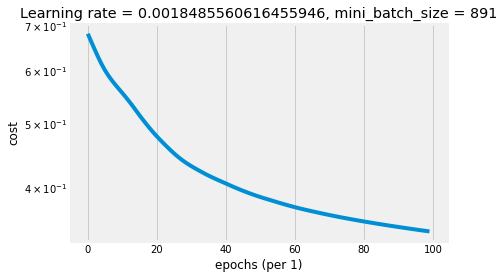

-0.46307596465915846


In [186]:
parameters = model(X_train_tp, Y_train_tp, layer_dims, optimizer = "adam", learning_rate = 0.005,
                   mini_batch_size = X_train_tp.shape[1], learning_decay = 0.01,
                   num_epochs = 100)

In [187]:
Y_predict, _ = forward_propagation(X_train_tp, parameters)
Y_predict.shape

(1, 891)

In [193]:
Y_predict[0,1]

0.9741100834484112

In [195]:
for i in range(len(Y_predict[0])):
    if Y_predict[0,i] >= 0.5:
        Y_predict[0,i] = 1
    else:
        Y_predict[0,i] = 0

In [196]:
Y_predict[0,1]

1.0

In [199]:
t_predict = 0
for s_p, s_t in zip(Y_predict[0], Y_train_tp[0]):
    if s_p == s_t:
        t_predict += 1
print("Accuracy: ", t_predict/len(Y_predict[0]))

Accuracy:  0.8698092031425365


In [200]:
X_test = test.iloc[:, 1:].values
X_test_tp = X_test.T

In [206]:
Y_predict, _ = forward_propagation(X_test_tp, parameters)
for i in range(len(Y_predict[0])):
    if Y_predict[0,i] >= 0.5:
        Y_predict[0,i] = int(1)
    else:
        Y_predict[0,i] = int(0)
Y_predict = Y_predict.T

In [218]:
Y_predict.astype(int)
Y_predict.shape

(418, 1)

In [215]:
submission = pd.DataFrame({
        "PassengerId": test.index,
        "Survived": Y_predict.astype(int).squeeze()})
submission.to_csv('titanic.csv', index=False)
#0.76076

In [219]:
#Y_predict.astype(int).squeeze()